Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book

[MIT License](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 13 - Parallelizing Neural Network Training with Theano

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,matplotlib,theano,keras

Using Theano backend.


Sebastian Raschka 
last updated: 2017-07-04 

CPython 3.6.1
IPython 6.0.0

numpy 1.13.0
matplotlib 2.0.2
theano 0.9.0
keras 2.0.5


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Building, compiling, and running expressions with Theano](#Building,-compiling,-and-running-expressions-with-Theano)
  - [What is Theano?](#What-is-Theano?)
  - [First steps with Theano](#First-steps-with-Theano)
  - [Configuring Theano](#Configuring-Theano)
  - [Working with array structures](#Working-with-array-structures)
  - [Wrapping things up – a linear regression example](#Wrapping-things-up:-A--linear-regression-example)
- [Choosing activation functions for feedforward neural networks](#Choosing-activation-functions-for-feedforward-neural-networks)
  - [Logistic function recap](#Logistic-function-recap)
  - [Estimating probabilities in multi-class classification via the softmax function](#Estimating-probabilities-in-multi-class-classification-via-the-softmax-function)
  - [Broadening the output spectrum by using a hyperbolic tangent](#Broadening-the-output-spectrum-by-using-a-hyperbolic-tangent)
- [Training neural networks efficiently using Keras](#Training-neural-networks-efficiently-using-Keras)
- [Summary](#Summary)

<br>
<br>

In [2]:
from IPython.display import Image

In [3]:
%matplotlib inline

# Building, compiling, and running expressions with Theano

Depending on your system setup, it is typically sufficient to install Theano via

    pip install Theano
    
For more help with the installation, please see: http://deeplearning.net/software/theano/install.html

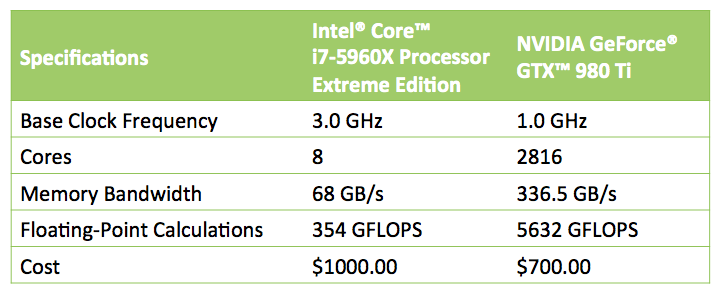

In [4]:
Image(filename='./images/13_01.png', width=500) 

<br>
<br>

## What is Theano?

...

## First steps with Theano

Introducing the TensorType variables. For a complete list, see http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors

In [5]:
import theano
from theano import tensor as T

In [6]:
# initialize
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# compile
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# execute
net_input(2.0, 1.0, 0.5)

array(2.5, dtype=float32)

<br>
<br>

## Configuring Theano

Configuring Theano. For more options, see
- http://deeplearning.net/software/theano/library/config.html
- http://deeplearning.net/software/theano/library/floatX.html

In [7]:
print(theano.config.floatX)

float32


In [8]:
theano.config.floatX = 'float32'

To change the float type globally, execute 

    export THEANO_FLAGS=floatX=float32 
    
in your bash shell. Or execute Python script as

    THEANO_FLAGS=floatX=float32 python your_script.py

Running Theano on GPU(s). For prerequisites, please see: http://deeplearning.net/software/theano/tutorial/using_gpu.html

Note that `float32` is recommended for GPUs; `float64` on GPUs is currently still relatively slow.

In [9]:
print(theano.config.device)

cpu


You can run a Python script on CPU via:

    THEANO_FLAGS=device=cpu,floatX=float64 python your_script.py

or GPU via

    THEANO_FLAGS=device=gpu,floatX=float32 python your_script.py

It may also be convenient to create a `.theanorc` file in your home directory to make those configurations permanent. For example, to always use `float32`, execute

    echo -e "\n[global]\nfloatX=float32\n" >> ~/.theanorc
    
Or, create a `.theanorc` file manually with the following contents

    [global]
    floatX = float32
    device = gpu


<br>
<br>

## Working with array structures

In [10]:
import numpy as np

# initialize
# if you are running Theano on 64 bit mode, 
# you need to use dmatrix instead of fmatrix
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

# compile
calc_sum = theano.function(inputs=[x], outputs=x_sum)

# execute (Python list)
ary = [[1, 2, 3], [1, 2, 3]]
print('Column sum:', calc_sum(ary))

# execute (NumPy array)
ary = np.array([[1, 2, 3], [1, 2, 3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]
Column sum: [ 2.  4.  6.]


Updating shared arrays.
More info about memory management in Theano can be found here: http://deeplearning.net/software/theano/tutorial/aliasing.html

In [11]:
# initialize
x = T.fmatrix(name='x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], 
                             dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[x], 
                            updates=update, 
                            outputs=z)

# execute
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


We can use the `givens` variable to insert values into the graph before compiling it. Using this approach we can reduce the number of transfers from RAM (via CPUs) to GPUs to speed up learning with shared variables. If we use `inputs`, a datasets is transferred from the CPU to the GPU multiple times, for example, if we iterate over a dataset multiple times (epochs) during gradient descent. Via `givens`, we can keep the dataset on the GPU if it fits (e.g., a mini-batch). 

In [12]:
# initialize
data = np.array([[1, 2, 3]], 
                dtype=theano.config.floatX)
x = T.fmatrix(name='x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], 
                             dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[], 
                            updates=update, 
                            givens={x: data},
                            outputs=z)

# execute
for i in range(5):
    print('z:', net_input())

z: [[ 0.]]
z: [[ 6.]]
z: [[ 12.]]
z: [[ 18.]]
z: [[ 24.]]


<br>
<br>

## Wrapping things up: A  linear regression example

Creating some training data.

In [13]:
import numpy as np
X_train = np.asarray([[0.0], [1.0], [2.0], [3.0], [4.0],
                      [5.0], [6.0], [7.0], [8.0], [9.0]], 
                     dtype=theano.config.floatX)

y_train = np.asarray([1.0, 1.3, 3.1, 2.0, 5.0, 
                      6.3, 6.6, 7.4, 8.0, 9.0], 
                     dtype=theano.config.floatX)

Implementing the training function.

In [14]:
import theano
from theano import tensor as T
import numpy as np

def train_linreg(X_train, y_train, eta, epochs):

    costs = []
    # Initialize arrays
    eta0 = T.fscalar('eta0')
    y = T.fvector(name='y') 
    X = T.fmatrix(name='X')   
    w = theano.shared(np.zeros(
                      shape=(X_train.shape[1] + 1),
                      dtype=theano.config.floatX),
                      name='w')
    
    # calculate cost
    net_input = T.dot(X, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2)) 

    # perform gradient update
    gradient = T.grad(cost, wrt=w)
    update = [(w, w - eta0 * gradient)]

    # compile model
    train = theano.function(inputs=[eta0],
                            outputs=cost,
                            updates=update,
                            givens={X: X_train,
                                    y: y_train})      
    
    for _ in range(epochs):
        costs.append(train(eta))
    
    return costs, w

Plotting the sum of squared errors cost vs epochs.

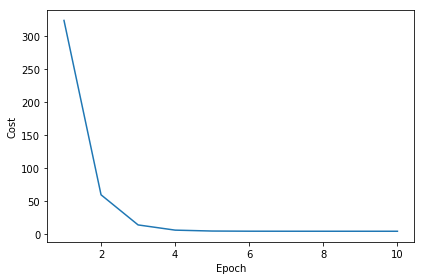

In [15]:
import matplotlib.pyplot as plt

costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
   
plt.plot(range(1, len(costs)+1), costs)

plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.tight_layout()
# plt.savefig('./figures/cost_convergence.png', dpi=300)
plt.show()

Making predictions.

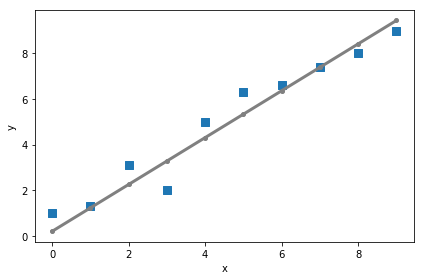

In [16]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], givens={w: w}, outputs=net_input)
    return predict(X)

plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]), 
         predict_linreg(X_train, w), 
         color='gray', 
         marker='o', 
         markersize=4, 
         linewidth=3)

plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
# plt.savefig('./figures/linreg.png', dpi=300)
plt.show()

<br>
<br>

# Choosing activation functions for feedforward neural networks

...

## Logistic function recap

The logistic function, often just called "sigmoid function" is in fact a special case of a sigmoid function.

Net input $z$:
$$z =  w_1x_{1} + \dots + w_mx_{m} = \sum_{j=1}^{m} x_{j}w_{j} \\ = \mathbf{w}^T\mathbf{x}$$

Logistic activation function:

$$\phi_{logistic}(z) = \frac{1}{1 +  e^{-z}}$$

Output range: (0, 1)

In [17]:
# note that first element (X[0] = 1) to denote bias unit

X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)[0])

P(y=1|x) = 0.707


Now, imagine a MLP perceptron with 3 hidden units + 1 bias unit in the hidden unit. The output layer consists of 3 output units.

In [18]:
# W : array, shape = [n_output_units, n_hidden_units+1]
#          Weight matrix for hidden layer -> output layer.
# note that first column (W[:][0]) contains the bias units
W = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])

# A : array, shape = [n_hidden+1, n_samples]
#          Activation of hidden layer.
# note that first element (A[0][0] = 1) is for the bias units

A = np.array([[1.0], 
              [0.1], 
              [0.3], 
              [0.7]])

# Z : array, shape = [n_output_units, n_samples]
#          Net input of output layer.

Z = W.dot(A) 
y_probas = logistic(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


In [19]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


<br>
<br>

## Estimating probabilities in multi-class classification via the softmax function

The softmax function is a generalization of the logistic function and allows us to compute meaningful class-probalities in multi-class settings (multinomial logistic regression).

$$P(y=j|z) =\phi_{softmax}(z) = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}$$

the input to the function is the result of K distinct linear functions, and the predicted probability for the j'th class given a sample vector x is:

Output range: (0, 1)

In [20]:
def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

In [21]:
y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]


In [22]:
y_probas.sum()

1.0

In [23]:
y_class = np.argmax(Z, axis=0)
y_class

array([2])

***Note***   
Below is an additional figure to illustrate the difference between logistic regression and softmax:

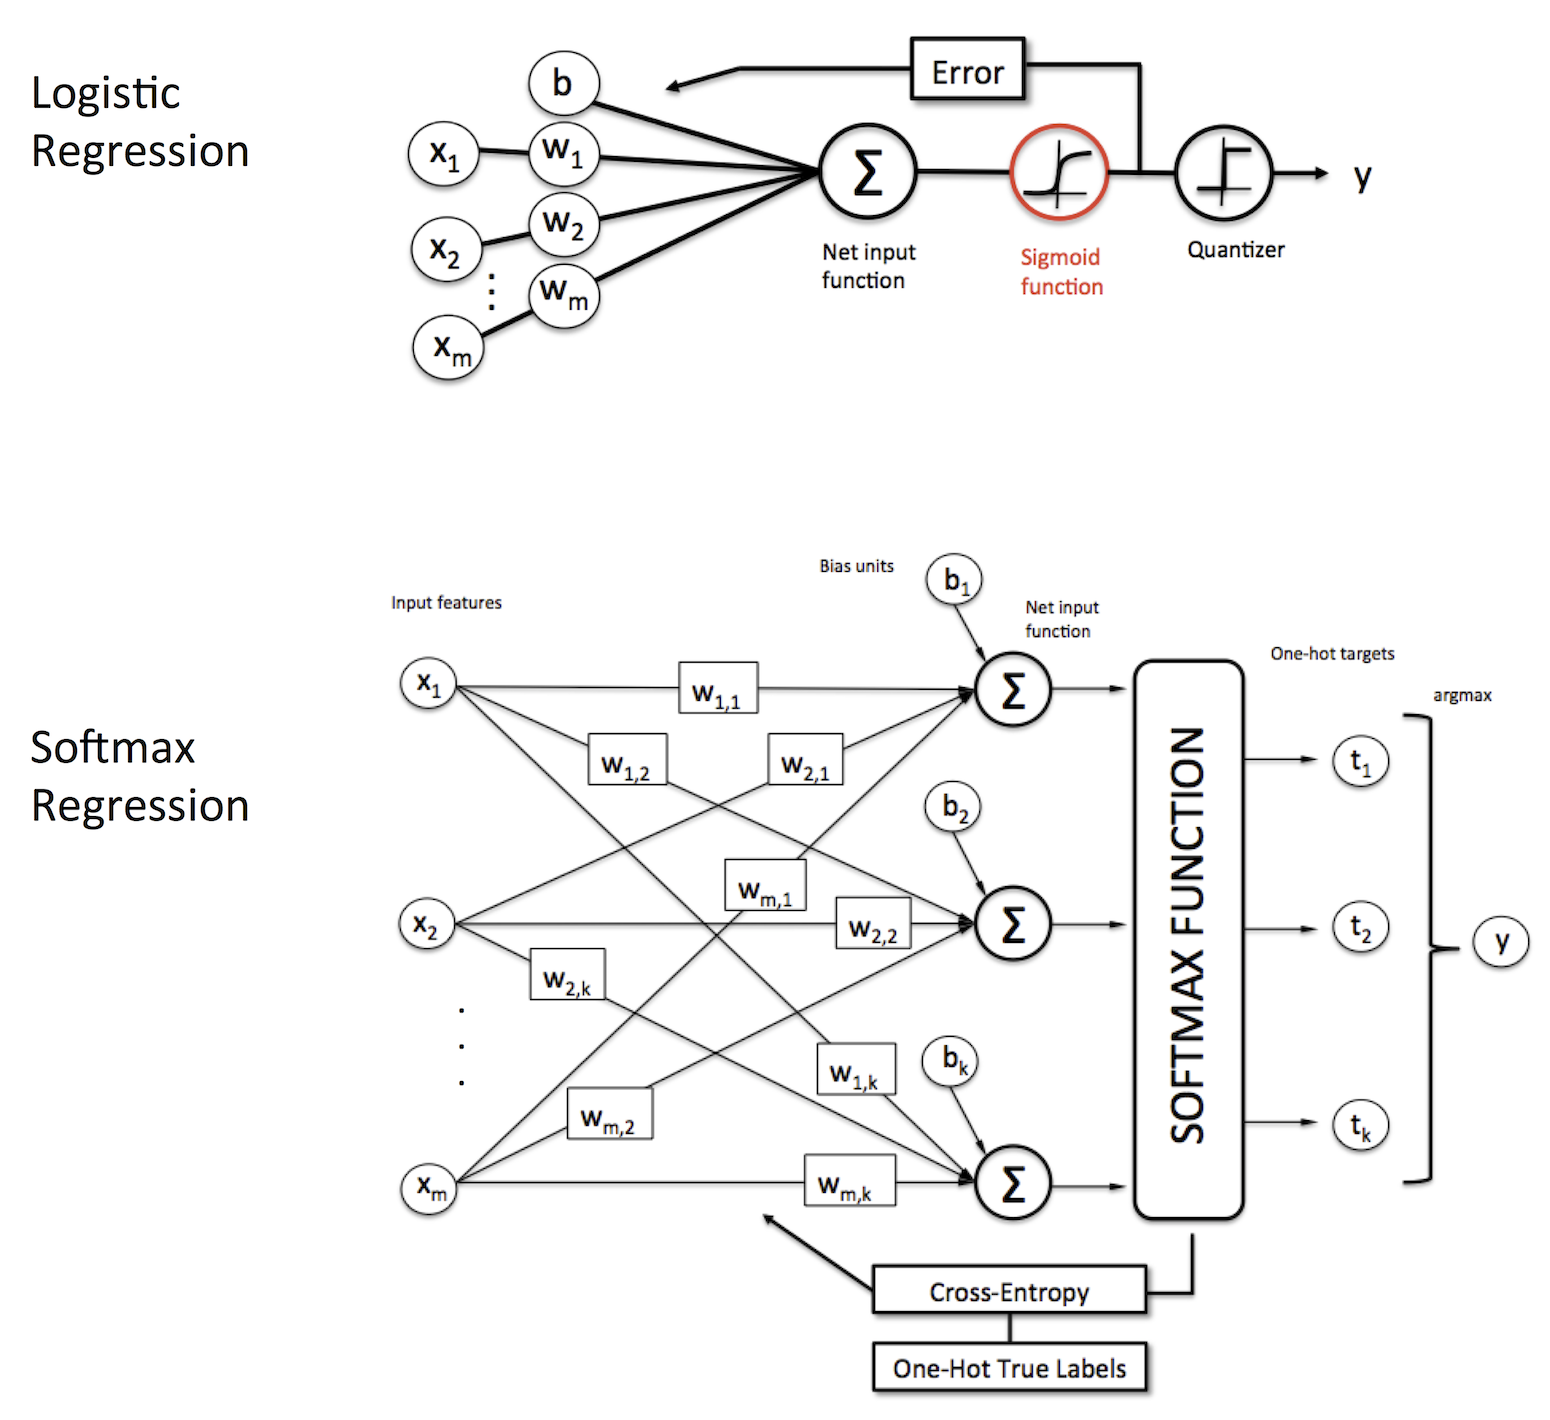

In [24]:
Image(filename='./images/bonus_softmax_1.png', width=800) 

<br>
<br>

## Broadening the output spectrum using a hyperbolic tangent

Another special case of a sigmoid function, it can be interpreted as a rescaled version of the logistic function.

$$\phi_{tanh}(z) = \frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}$$

Output range: (-1, 1)

In [25]:
def tanh(z):
    e_p = np.exp(z) 
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)  

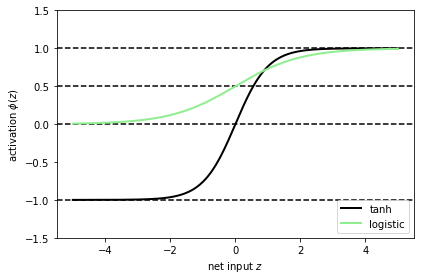

In [26]:
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

# alternatives:
# from scipy.special import expit
# log_act = expit(z)
# tanh_act = np.tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')

plt.plot(z, tanh_act, 
         linewidth=2, 
         color='black', 
         label='tanh')
plt.plot(z, log_act, 
         linewidth=2, 
         color='lightgreen', 
         label='logistic')

plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/activation.png', dpi=300)
plt.show()

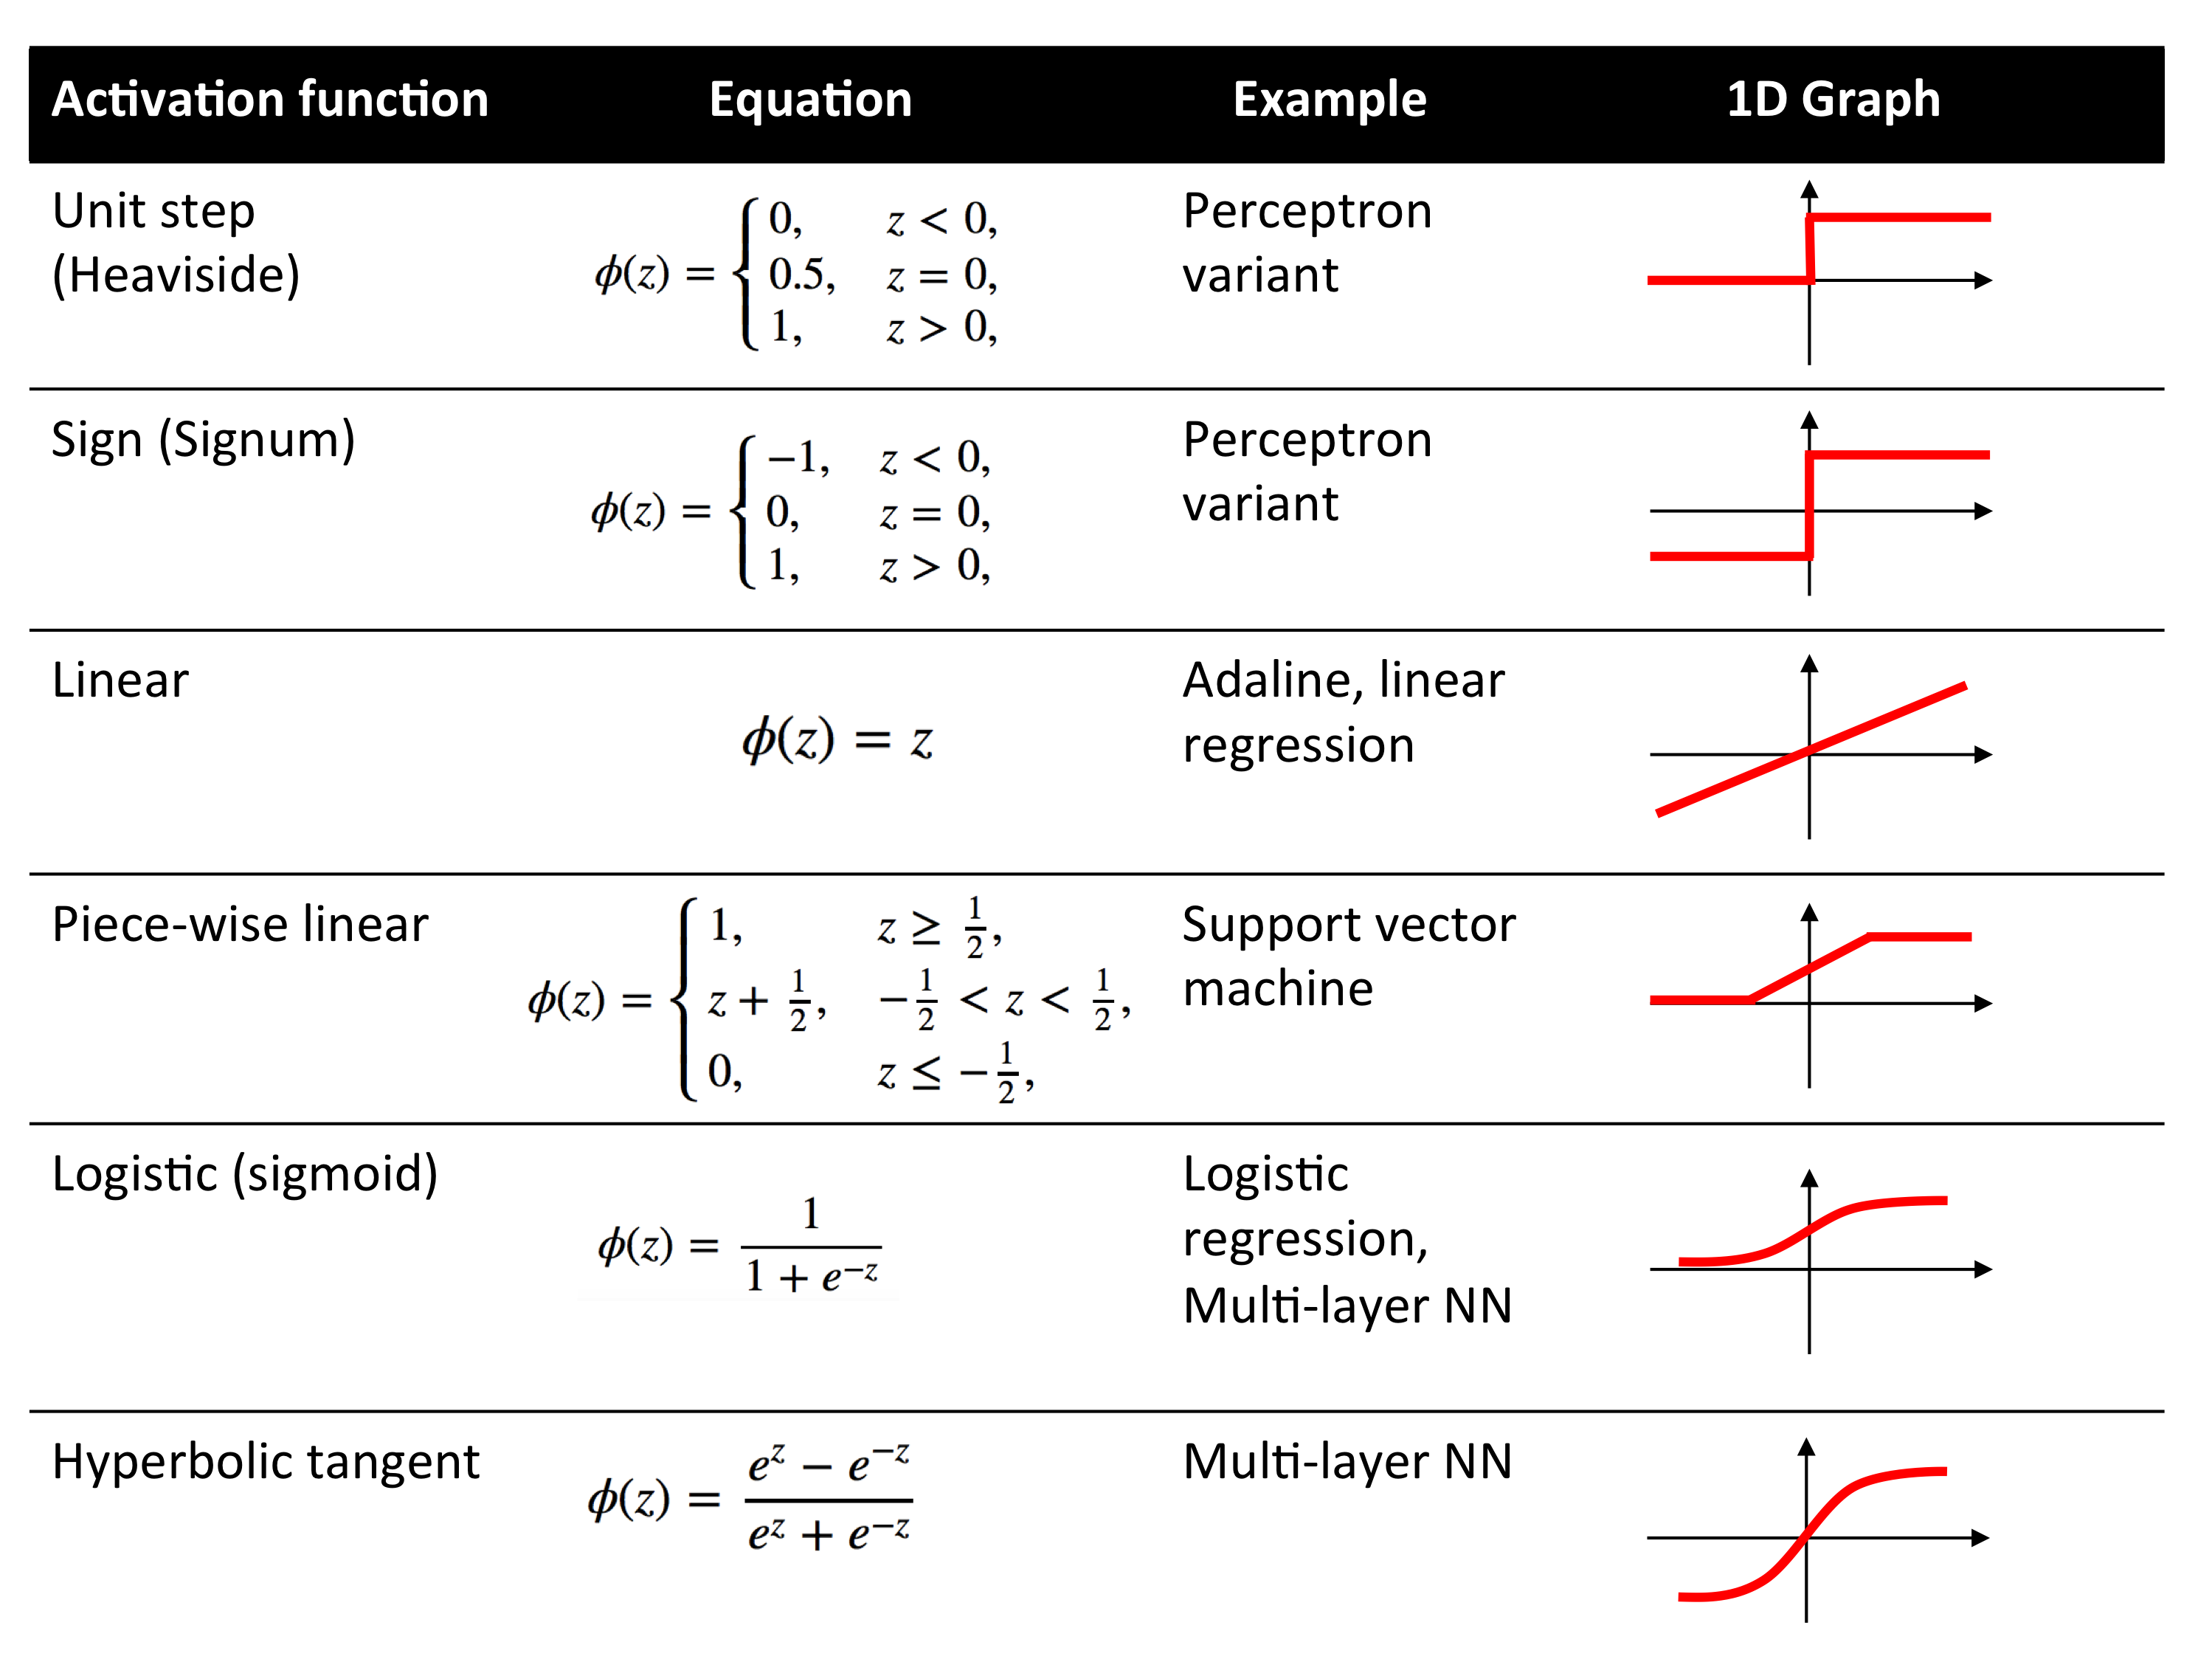

In [27]:
Image(filename='./images/13_05.png', width=700) 

<br>
<br>

# Training neural networks efficiently using Keras

--- 
**Note about installing Keras**

As a [kind reader pointed out](http://www.mostafaelzoghbi.com/2017/04/how-to-install-keras-on-windows-10-64.html), Keras can now be installed from conda-forge, which is a community-driven effort to make packages available to the conda manager -- if you have troubles installing Keras via `pip` (`pip install keras`). To install Keras from conda-forge, you need to specify the respective conda channel as shown below:

```bash
conda install -c conda-forge keras=2.0.2
```

(End of note.)

---

### Loading MNIST

1) Download the 4 MNIST datasets from http://yann.lecun.com/exdb/mnist/

- train-images-idx3-ubyte.gz:  training set images (9912422 bytes) 
- train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) 
- t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes) 
- t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

2) Unzip those files

3 Copy the unzipped files to a directory `./mnist`

In [28]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [29]:
X_train, y_train = load_mnist('./mnist', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [30]:
X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


### Multi-layer Perceptron in Keras

Once you have Theano installed, [Keras](https://github.com/fchollet/keras) can be installed via

    pip install Keras

In order to run the following code via GPU, you can execute the Python script that was placed in this directory via

    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python mnist_keras_mlp.py

In [31]:
import theano 

theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

One-hot encoding of the class variable:

In [32]:
from keras.utils import np_utils

print('First 3 labels: ', y_train[:3])

y_train_ohe = np_utils.to_categorical(y_train) 
print('\nFirst 3 labels (one-hot):\n', y_train_ohe[:3])

First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [33]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1) 

model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], 
                units=50, # formerly output_dim=50 in Keras < 2
                kernel_initializer='uniform', # formerly init='uniform' in Keras < 2
                activation='tanh'))

model.add(Dense(input_dim=50, 
                units=50, 
                kernel_initializer='uniform', 
                activation='tanh'))

model.add(Dense(input_dim=50, 
                units=y_train_ohe.shape[1],
                kernel_initializer='uniform', 
                activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy'])

model.fit(X_train, y_train_ohe, 
          epochs=50, # Keras 2: former nb_epoch has been renamed to epochs
          batch_size=300, 
          verbose=1, 
          validation_split=0.1) 
          # removed former show_accuracy=True 
          # and added `metrics=['accuracy']` to the
          # model.compile call for Keras >= 2

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 0s - loss: 2.2244 - acc: 0.4249 - val_loss: 2.1019 - val_acc: 0.5712
Epoch 2/50
54000/54000 [==============================] - 0s - loss: 1.8746 - acc: 0.5297 - val_loss: 1.5900 - val_acc: 0.5878
Epoch 3/50
54000/54000 [==============================] - 0s - loss: 1.3850 - acc: 0.6134 - val_loss: 1.1486 - val_acc: 0.7050
Epoch 4/50
54000/54000 [==============================] - 0s - loss: 1.0424 - acc: 0.7195 - val_loss: 0.8696 - val_acc: 0.7933
Epoch 5/50
54000/54000 [==============================] - 0s - loss: 0.8236 - acc: 0.7928 - val_loss: 0.6872 - val_acc: 0.8498
Epoch 6/50
54000/54000 [==============================] - 0s - loss: 0.6819 - acc: 0.8328 - val_loss: 0.5700 - val_acc: 0.8740
Epoch 7/50
54000/54000 [==============================] - 0s - loss: 0.5867 - acc: 0.8578 - val_loss: 0.5052 - val_acc: 0.8860
Epoch 8/50
54000/54000 [==============================] - 0s -

In [34]:
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

train_acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

First 3 predictions:  [5 0 4]
Training accuracy: 94.43%
Test accuracy: 93.90%


<br>
<br>

# Summary

...